In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from ecpaper_utils import fig_utils as ecfig
from ecpaper_utils import bootstrap_utils as boot
from ecpaper_utils import shapefile_utils as shp
from ecpaper_utils import linfit_utils as linfit

importlib.reload(ecfig)
importlib.reload(boot)
importlib.reload(ecfig)

from math import nan
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 


In [2]:
datapath="/project/cas/islas/python_savs/ecpaper2020/DATASORT/VWIND/"

In [3]:
cmip5prmap = xr.open_dataset(datapath+"cmip5vwind_prmapdata.nc")
cmip6prmap = xr.open_dataset(datapath+"cmip6vwind_prmapdata.nc")
cmip5indices = xr.open_dataset(datapath+"cmip5vwindindices.nc")
cmip6indices = xr.open_dataset(datapath+"cmip6vwindindices.nc")
cmip5prindices = xr.open_dataset(datapath+"cmip5vwind_prdata.nc")
cmip6prindices = xr.open_dataset(datapath+"cmip6vwind_prdata.nc")

In [4]:
errorpath="../ERRORCALC/VWIND/DATA/"
error5path = errorpath+"errors_cmip5.nc"
error6path = errorpath+"errors_cmip6.nc"
error5 = xr.open_dataset(error5path)
error6 = xr.open_dataset(error6path)

In [5]:
cmip5prmapcor = xr.corr(cmip5indices['vpastamp_em'], cmip5prmap['prdif'], dim="Model")
cmip6prmapcor = xr.corr(cmip6indices['vpastamp_em'], cmip6prmap['prdif'], dim="Model")
signifmapcmip5 = boot.boot_corr_signif(cmip5indices['vpastamp_em'], cmip5prmap['prdif'], 95, dim="Model", nboots=1000)
signifmapcmip6 = boot.boot_corr_signif(cmip6indices['vpastamp_em'], cmip6prmap['prdif'], 95, dim="Model", nboots=1000)

In [6]:
dims = cmip5indices['vpastamp_em']

In [7]:
obsdata=xr.open_dataset(datapath+"vampobs.nc")
vampobs=np.zeros([4])
vampobs[0]=obsdata.vamp_era5 ; vampobs[1]=obsdata.vamp_erai
vampobs[2]=obsdata.vamp_jra ; vampobs[3]=obsdata.vamp_merra

In [8]:
# region masks - used for red contours on maps
maskcoords = cmip5prmap['prdif'].isel(Model=0)
shpdir="/project/cas/islas/python/ecpaper2020/shapefiles/USA/"
shpfile_USA = shpdir+"gadm36_USA_1.shp"
shpdir = "/project/cas/islas/python/ecpaper2020/shapefiles/Mexico/"
shpfile_MEX = shpdir+"gadm36_MEX_0.shp"

maskwest = shp.maskgen(shpfile_USA, maskcoords, ['California','Oregon','Washington'])
masksouth = shp.maskgen(shpfile_USA, maskcoords, 
                    ['Texas', 'New Mexico', 'Louisiana', 'Alabama', 'Mississippi', 'Oklahoma', 'Arkansas'])
maskmex = shp.maskgen(shpfile_MEX, maskcoords,['Mexico'])
lat2d = np.repeat(np.expand_dims(maskmex.lat, axis=1), maskmex.lon.size, axis=1)
maskmex = np.where(lat2d > 22, nan, maskmex)
maskmex = xr.DataArray(maskmex, coords = maskcoords.coords)

maskwest = np.nan_to_num(maskwest)
masksouth = np.nan_to_num(masksouth)
maskmex = np.nan_to_num(maskmex)

masking California
masking Oregon
masking Washington
masking Texas
masking New Mexico
masking Louisiana
masking Alabama
masking Mississippi
masking Oklahoma
masking Arkansas
masking Mexico


In [9]:
def format_map(ax):
    ax.set_aspect('auto')
    ax.set_extent([-170, -50, 10, 80], crs = ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)

    ax.set_xticks([-160, -130, -100, -70], crs=ccrs.PlateCarree())
    ax.set_yticks([20, 40, 60, 80], crs=ccrs.PlateCarree())
    
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True, 
                                                   degree_symbol=''))
    ax.yaxis.set_major_formatter(LatitudeFormatter(degree_symbol=''))

Map panels (a) and (b)

/project/cas/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


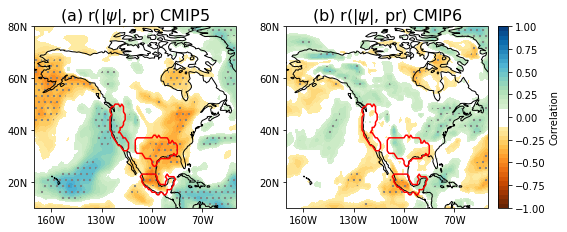

In [10]:
prcol = ecfig.combine_cmaps(n = 18, white = 4, neg = "YlOrBr", pos = "GnBu", start = 0.2)
prbreaks = np.arange(-1, 1.05, 0.05)
lons = cmip5prmapcor.lon
lats = cmip5prmapcor.lat

fig = plt.figure(figsize = (10, 14))

plt.rcParams['hatch.color'] = "gray"

ax1 = fig.add_axes(np.array([0.05, 0.8, 0.28, 0.18]), projection = ccrs.PlateCarree())
cf = ax1.contourf(lons, lats,cmip5prmapcor, cmap = prcol, levels=prbreaks, transform=ccrs.PlateCarree())
cf2 = ax1.contourf(lons, lats, signifmapcmip5, levels=[0,0.5,1], hatches=["",".."], alpha=0, transform=ccrs.PlateCarree())
cf3 = ax1.contour(lons, lats, np.array(maskwest), levels=[0, 1], colors='red')
cf4 = ax1.contour(lons, lats, np.array(masksouth), levels=[0,1], colors='red')
cf5 = ax1.contour(lons, lats, np.array(maskmex), levels=[0,1], colors='red')
ax1.set_title("(a) r($|\psi|$, pr) CMIP5", fontsize=16)
format_map(ax1)

ax2 = fig.add_axes(np.array([0.4 , 0.8, 0.28, 0.18]), projection = ccrs.PlateCarree())
cf = ax2.contourf(lons, lats, cmip6prmapcor, cmap = prcol, levels=prbreaks, transform=ccrs.PlateCarree())
cf2 = ax2.contourf(lons, lats, signifmapcmip6, levels=[0,0.5,1], hatches=["",".."], alpha=0, transform=ccrs.PlateCarree())
cf3 = ax2.contour(lons, lats, np.array(maskwest), levels=[0, 1], colors='red')
cf4 = ax2.contour(lons, lats, np.array(masksouth), levels=[0,1], colors='red')
cf5 = ax2.contour(lons, lats, np.array(maskmex), levels=[0,1], colors='red')
ax2.set_title("(b) r($|\psi|$, pr) CMIP6", fontsize=16)
format_map(ax2)

axins = inset_axes(ax2, width="5%", height="100%", bbox_to_anchor=(0.1, 0, 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
fig.colorbar(cf, cax=axins, label="Correlation")

US west coast panels (c)-(e)

In [11]:
# regression lines
aols5, bols5 = linfit.linfit_xy(cmip5indices['vpastamp_em'], cmip5prindices['prwest_f_em']-cmip5prindices['prwest_p_em'], sigma=error5['sig_pdiff_west'])
atls5, btls5 = linfit.tls(cmip5indices['vpastamp_em'], cmip5prindices['prwest_f_em']-cmip5prindices['prwest_p_em'], error5['sig_psi'], error5['sig_pdiff_west'])
abhmall, bbhmall, del2all, muxall, delx2all = linfit.bhm(cmip5indices['vpastamp_em'], cmip5prindices['prwest_f_em']-cmip5prindices['prwest_p_em'], error5['sig_psi'], error5['sig_pdiff_west'],
                       error5['r_psi_prwest'])
abhm5 = np.mean(abhmall) ; bbhm5 = np.mean(bbhmall)

aols6, bols6 = linfit.linfit_xy(cmip6indices['vpastamp_em'], cmip6prindices['prwest_f_em']-cmip6prindices['prwest_p_em'], sigma=error6['sig_pdiff_west'])
atls6, btls6 = linfit.tls(cmip6indices['vpastamp_em'], cmip6prindices['prwest_f_em']-cmip6prindices['prwest_p_em'], error6['sig_psi'], error6['sig_pdiff_west'])
abhmall, bbhmall, del2all, muxall, delx2all = linfit.bhm(cmip6indices['vpastamp_em'], cmip6prindices['prwest_f_em']-cmip6prindices['prwest_p_em'], error6['sig_psi'], error6['sig_pdiff_west'],
                       error6['r_psi_prwest'])
abhm6 = np.mean(abhmall) ; bbhm6 = np.mean(bbhmall)

In [12]:
xlim=(1,6)
ylim=(-1,1.6)
xvals = np.arange(xlim[0], xlim[1]+1, 1)

ax3 = fig.add_axes(np.array([0.05,0.57, 0.28, 0.18]))
ax3 = ecfig.vwindprscattersetup(ax3, ylim, '(c) CMIP5 US west coast', obsdata)
ax3.set_yticks([-1,-0.5,0,0.5,1,1.5])
ax3.set_yticklabels(['-1','-0.5','0','0.5','1','1.5'], fontsize=14)
ax3.set_ylabel('$\Delta$pr (mm/day)', fontsize=14, labelpad=-1)
ax3.plot(xvals, aols5 + bols5*xvals, color='saddlebrown', linewidth=3, linestyle='dashed')
ax3.plot(xvals, atls5 + btls5*xvals, color='forestgreen', linewidth=3, linestyle='dashed')
ax3.plot(xvals, abhm5 + bbhm5*xvals, color='blueviolet', linewidth=3, linestyle='dashed')
ax3.plot(cmip5indices['vpastamp_em'], cmip5prindices['prwest_f_em']-cmip5prindices['prwest_p_em'], "o", markerfacecolor="firebrick", markeredgecolor="black",
        markersize=10, markeredgewidth=2, label="CMIP5")
ax3.plot(cmip5indices['vpastamp_em'].mean(), cmip5prindices['prwest_f_em'].mean()-cmip5prindices['prwest_p_em'].mean(), "D", markerfacecolor="firebrick", markeredgecolor="black",
        markersize=15, markeredgewidth=2, label="CMIP5")
ax3.errorbar(cmip5indices['vpastamp_em'], cmip5prindices['prwest_f_em']-cmip5prindices['prwest_p_em'], xerr=1.96*error5['sig_psi'], yerr=1.96*error5['sig_pdiff_west'],
            color='lightgray', linewidth=2, linestyle="None")

ax4 = fig.add_axes(np.array([0.4, 0.57, 0.28, 0.18]))
ax4 = ecfig.vwindprscattersetup(ax4, ylim, '(d) CMIP6 US west coast', obsdata)
ax4.set_yticks([-1,-0.5,0,0.5,1,1.5])
ax4.set_yticklabels(['-1','-0.5','0','0.5','1','1.5'], fontsize=14)
ax4.set_ylabel(' ', fontsize=14, labelpad=-1)
ax4.plot(xvals, aols6 + bols6*xvals, color='saddlebrown', linewidth=3, linestyle='dashed')
ax4.plot(xvals, atls6 + btls6*xvals, color='forestgreen', linewidth=3, linestyle='dashed')
ax4.plot(xvals, abhm6 + bbhm6*xvals, color='blueviolet', linewidth=3, linestyle='dashed')
ax4.plot(cmip6indices['vpastamp_em'], cmip6prindices['prwest_f_em']-cmip6prindices['prwest_p_em'], "o", markerfacecolor="royalblue", markeredgecolor="black",
        markersize=10, markeredgewidth=2, label="CMIP6")
ax4.plot(cmip6indices['vpastamp_em'].mean(), cmip6prindices['prwest_f_em'].mean()-cmip6prindices['prwest_p_em'].mean(), "D", markerfacecolor="royalblue", markeredgecolor="black",
        markersize=15, markeredgewidth=2, label="CMIP5")
ax4.errorbar(cmip6indices['vpastamp_em'], cmip6prindices['prwest_f_em']-cmip6prindices['prwest_p_em'], xerr=1.96*error6['sig_psi'], yerr=1.96*error6['sig_pdiff_west'],
            color='lightgray', linewidth=2, linestyle="None")


ax5 = fig.add_axes(np.array([0.77, 0.57, 0.17, 0.18]))
r5 = xr.corr(cmip5indices['vpastamp_em'], cmip5prindices['prwest_f_em']-cmip5prindices['prwest_p_em'])
minr5, maxr5 = boot.boot_corr_ci(cmip5indices['vpastamp_em'], cmip5prindices['prwest_f_em']-cmip5prindices['prwest_p_em'], 95)
r6 = xr.corr(cmip6indices['vpastamp_em'], cmip6prindices['prwest_f_em']-cmip6prindices['prwest_p_em'])
minr6, maxr6 = boot.boot_corr_ci(cmip6indices['vpastamp_em'], cmip6prindices['prwest_f_em']-cmip6prindices['prwest_p_em'], 95)

indices = np.where(cmip5indices['vpastamp_em'] < np.max(cmip6indices['vpastamp_em']))
ampuse = cmip5indices['vpastamp_em'][indices]
prdifuse = cmip5prindices['prwest_f_em'][indices]-cmip5prindices['prwest_p_em'][indices]
r5star = xr.corr(ampuse, prdifuse)
minr5star, maxr5star = boot.boot_corr_ci(ampuse, prdifuse, 95)

ax5.set_ylim(-1,1)
ax5.set_yticks(np.arange(-1,1.2,0.2))
ax5.set_yticklabels(['-1','-0.8','-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
ax5.set_ylabel('Correlation', fontsize=14, labelpad=-1)
ax5.set_title('(e) US west coast', fontsize=16)
ax5.set_xlim(0,4)
ax5.plot([0,4],[0,0], color='black')
ax5.bar(1,r5,bottom=None, width=1, facecolor='firebrick', edgecolor='black', linewidth=2)
ax5.errorbar(1, r5, [[r5-minr5], [maxr5-r5]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.bar(2,r6,bottom=None, width=1, facecolor='royalblue', edgecolor='black', linewidth=2)
ax5.errorbar(2, r6, [[r6-minr6], [maxr6-r6]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.bar(3,r5star, bottom=None, width=1, fill=False, linewidth=2, hatch="////", edgecolor='red')
ax5.bar(3,r5star, bottom=None, width=1, fill=False, linewidth=2, edgecolor='black')
ax5.errorbar(3, r5star, [[r5star-minr5star], [maxr5star-r5star]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.set_xticks([1,2,3])
ax5.set_xticklabels(['','',''])


[Text(1, 0, ''), Text(2, 0, ''), Text(3, 0, '')]

US south panels (f)-(h)

In [13]:
# regression lines
aols5, bols5 = linfit.linfit_xy(cmip5indices['vpastamp_em'], cmip5prindices['prsouth_f_em']-cmip5prindices['prsouth_p_em'], sigma=error5['sig_pdiff_south'])
atls5, btls5 = linfit.tls(cmip5indices['vpastamp_em'], cmip5prindices['prsouth_f_em']-cmip5prindices['prsouth_p_em'], error5['sig_psi'], error5['sig_pdiff_south'])
abhmall, bbhmall, del2all, muxall, delx2all = linfit.bhm(cmip5indices['vpastamp_em'], cmip5prindices['prsouth_f_em']-cmip5prindices['prsouth_p_em'], error5['sig_psi'], 
                                                         error5['sig_pdiff_south'],error5['r_psi_prsouth'])
abhm5 = np.mean(abhmall) ; bbhm5 = np.mean(bbhmall)

aols6, bols6 = linfit.linfit_xy(cmip6indices['vpastamp_em'], cmip6prindices['prsouth_f_em']-cmip6prindices['prsouth_p_em'], sigma=error6['sig_pdiff_south'])
atls6, btls6 = linfit.tls(cmip6indices['vpastamp_em'], cmip6prindices['prsouth_f_em']-cmip6prindices['prsouth_p_em'], error6['sig_psi'], error6['sig_pdiff_south'])
abhmall, bbhmall, del2all, muxall, delx2all = linfit.bhm(cmip6indices['vpastamp_em'], cmip6prindices['prsouth_f_em']-cmip6prindices['prsouth_p_em'], error6['sig_psi'], 
                                                         error6['sig_pdiff_south'],error6['r_psi_prsouth'])
abhm6 = np.mean(abhmall) ; bbhm6 = np.mean(bbhmall)

In [14]:
xlim=(1,6)
ylim=(-1,1)
xvals = np.arange(xlim[0], xlim[1]+1, 1)

ax3 = fig.add_axes(np.array([0.05,0.34, 0.28, 0.18]))
ax3 = ecfig.vwindprscattersetup(ax3, ylim, '(f) CMIP5 US south', obsdata)
ax3.set_yticks([-1,-0.5,0,0.5,1])
ax3.set_yticklabels(['-1','-0.5','0','0.5','1'], fontsize=14)
ax3.set_ylabel('$\Delta$pr (mm/day)', fontsize=14, labelpad=-1)
ax3.plot(xvals, aols5 + bols5*xvals, color='saddlebrown', linewidth=3, linestyle='dashed')
ax3.plot(xvals, atls5 + btls5*xvals, color='forestgreen', linewidth=3, linestyle='dashed')
ax3.plot(xvals, abhm5 + bbhm5*xvals, color='blueviolet', linewidth=3, linestyle='dashed')
ax3.plot(cmip5indices['vpastamp_em'], cmip5prindices['prsouth_f_em']-cmip5prindices['prsouth_p_em'], "o", markerfacecolor="firebrick", markeredgecolor="black",
        markersize=10, markeredgewidth=2, label="CMIP5")
ax3.plot(cmip5indices['vpastamp_em'].mean(), cmip5prindices['prsouth_f_em'].mean()-cmip5prindices['prsouth_p_em'].mean(), "D", markerfacecolor="firebrick", markeredgecolor="black",
        markersize=15, markeredgewidth=2, label="CMIP5")
ax3.errorbar(cmip5indices['vpastamp_em'], cmip5prindices['prsouth_f_em']-cmip5prindices['prsouth_p_em'], xerr=1.96*error5['sig_psi'], yerr=1.96*error5['sig_pdiff_south'],
            color='lightgray', linewidth=2, linestyle="None")


ax4 = fig.add_axes(np.array([0.4, 0.34, 0.28, 0.18]))
ax4 = ecfig.vwindprscattersetup(ax4, ylim, '(g) CMIP6 US south', obsdata)
ax4.set_yticks([-1,-0.5,0,0.5,1])
ax4.set_yticklabels(['-1','-0.5','0','0.5','1'], fontsize=14)
ax4.set_ylabel(' ', fontsize=14, labelpad=-1)
ax4.plot(xvals, aols6 + bols6*xvals, color='saddlebrown', linewidth=3, linestyle='dashed')
ax4.plot(xvals, atls6 + btls6*xvals, color='forestgreen', linewidth=3, linestyle='dashed')
ax4.plot(xvals, abhm6 + bbhm6*xvals, color='blueviolet', linewidth=3, linestyle='dashed')
ax4.plot(cmip6indices['vpastamp_em'], cmip6prindices['prsouth_f_em']-cmip6prindices['prsouth_p_em'], "o", markerfacecolor="royalblue", markeredgecolor="black",
        markersize=10, markeredgewidth=2, label="CMIP6")
ax4.plot(cmip6indices['vpastamp_em'].mean(), cmip6prindices['prsouth_f_em'].mean()-cmip6prindices['prsouth_p_em'].mean(), "D", markerfacecolor="royalblue", markeredgecolor="black",
        markersize=15, markeredgewidth=2, label="CMIP5")
ax4.errorbar(cmip6indices['vpastamp_em'], cmip6prindices['prsouth_f_em']-cmip6prindices['prsouth_p_em'], xerr=1.96*error6['sig_psi'], yerr=1.96*error6['sig_pdiff_south'],
            color='lightgray', linewidth=2, linestyle="None")

ax5 = fig.add_axes(np.array([0.77, 0.34, 0.17, 0.18]))
r5 = xr.corr(cmip5indices['vpastamp_em'], cmip5prindices['prsouth_f_em']-cmip5prindices['prsouth_p_em'])
minr5, maxr5 = boot.boot_corr_ci(cmip5indices['vpastamp_em'], cmip5prindices['prsouth_f_em']-cmip5prindices['prsouth_p_em'], 95)
r6 = xr.corr(cmip6indices['vpastamp_em'], cmip6prindices['prsouth_f_em']-cmip6prindices['prsouth_p_em'])
minr6, maxr6 = boot.boot_corr_ci(cmip6indices['vpastamp_em'], cmip6prindices['prsouth_f_em']-cmip6prindices['prsouth_p_em'], 95)

indices = np.where(cmip5indices['vpastamp_em'] < np.max(cmip6indices['vpastamp_em']))
ampuse = cmip5indices['vpastamp_em'][indices]
prdifuse = cmip5prindices['prsouth_f_em'][indices]-cmip5prindices['prsouth_p_em'][indices]
r5star = xr.corr(ampuse, prdifuse)
minr5star, maxr5star = boot.boot_corr_ci(ampuse, prdifuse, 95)

ax5.set_ylim(-1,1)
ax5.set_yticks(np.arange(-1,1.2,0.2))
ax5.set_yticklabels(['-1','-0.8','-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
ax5.set_ylabel('Correlation', fontsize=14, labelpad=-1)
ax5.set_title('(h) US south', fontsize=16)
ax5.set_xlim(0,4)
ax5.plot([0,4],[0,0], color='black')
ax5.bar(1,r5,bottom=None, width=1, facecolor='firebrick', edgecolor='black', linewidth=2)
ax5.errorbar(1, r5, [[r5-minr5], [maxr5-r5]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.bar(2,r6,bottom=None, width=1, facecolor='royalblue', edgecolor='black', linewidth=2)
ax5.errorbar(2, r6, [[r6-minr6], [maxr6-r6]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.bar(3,r5star, bottom=None, width=1, fill=False, linewidth=2, hatch="////", edgecolor='red')
ax5.bar(3,r5star, bottom=None, width=1, fill=False, linewidth=2, edgecolor='black')
ax5.errorbar(3, r5star, [[r5star-minr5star], [maxr5star-r5star]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.set_xticks([1,2,3])
ax5.set_xticklabels(['','',''])

[Text(1, 0, ''), Text(2, 0, ''), Text(3, 0, '')]

Southern Mexico

In [15]:
# regression lines
aols5, bols5 = linfit.linfit_xy(cmip5indices['vpastamp_em'], cmip5prindices['prmex_f_em']-cmip5prindices['prmex_p_em'], sigma=error5['sig_pdiff_mex'])
atls5, btls5 = linfit.tls(cmip5indices['vpastamp_em'], cmip5prindices['prmex_f_em']-cmip5prindices['prmex_p_em'], error5['sig_psi'], error5['sig_pdiff_mex'])
abhmall, bbhmall, del2all, muxall, delx2all = linfit.bhm(cmip5indices['vpastamp_em'], cmip5prindices['prmex_f_em']-cmip5prindices['prmex_p_em'], error5['sig_psi'], 
                                                         error5['sig_pdiff_mex'],error5['r_psi_prmex'])
abhm5 = np.mean(abhmall) ; bbhm5 = np.mean(bbhmall)

aols6, bols6 = linfit.linfit_xy(cmip6indices['vpastamp_em'], cmip6prindices['prmex_f_em']-cmip6prindices['prmex_p_em'], sigma=error6['sig_pdiff_mex'])
atls6, btls6 = linfit.tls(cmip6indices['vpastamp_em'], cmip6prindices['prmex_f_em']-cmip6prindices['prmex_p_em'], error6['sig_psi'], error6['sig_pdiff_mex'])
abhmall, bbhmall, del2all, muxall, delx2all = linfit.bhm(cmip6indices['vpastamp_em'], cmip6prindices['prmex_f_em']-cmip6prindices['prmex_p_em'], error6['sig_psi'], 
                                                         error6['sig_pdiff_mex'],error6['r_psi_prmex'])
abhm6 = np.mean(abhmall) ; bbhm6 = np.mean(bbhmall)

In [16]:
xlim=(1,6)
ylim=(-1.5,0.5)
xvals = np.arange(xlim[0], xlim[1]+1, 1)

ax3 = fig.add_axes(np.array([0.05,0.11, 0.28, 0.18]))
ax3 = ecfig.vwindprscattersetup(ax3, ylim, '(i) CMIP5 South Mexico', obsdata)
ax3.set_yticks([-1.5,-1,-0.5,0,0.5])
ax3.set_yticklabels(['-1.5','-1','-0.5','0','0.5'], fontsize=14)
ax3.set_xlabel("|$\psi$| (ms$^{-1}$)", fontsize=14)
ax3.set_ylabel('$\Delta$pr (mm/day)', fontsize=14, labelpad=-1)
ax3.plot(xvals, aols5 + bols5*xvals, color='saddlebrown', linewidth=3, linestyle='dashed')
ax3.plot(xvals, atls5 + btls5*xvals, color='forestgreen', linewidth=3, linestyle='dashed')
ax3.plot(xvals, abhm5 + bbhm5*xvals, color='blueviolet', linewidth=3, linestyle='dashed')
ax3.plot(cmip5indices['vpastamp_em'], cmip5prindices['prmex_f_em']-cmip5prindices['prmex_p_em'], "o", markerfacecolor="firebrick", markeredgecolor="black",
        markersize=10, markeredgewidth=2, label="CMIP5")
ax3.plot(cmip5indices['vpastamp_em'].mean(), cmip5prindices['prmex_f_em'].mean()-cmip5prindices['prmex_p_em'].mean(), "D", markerfacecolor="firebrick", markeredgecolor="black",
        markersize=15, markeredgewidth=2, label="CMIP5")
ax3.errorbar(cmip5indices['vpastamp_em'], cmip5prindices['prmex_f_em']-cmip5prindices['prmex_p_em'], xerr=1.96*error5['sig_psi'], yerr=1.96*error5['sig_pdiff_mex'],
            color='lightgray', linewidth=2, linestyle="None")

ax4 = fig.add_axes(np.array([0.4, 0.11, 0.28, 0.18]))
ax4 = ecfig.vwindprscattersetup(ax4, ylim, '(j) CMIP6 South Mexico', obsdata)
ax4.set_yticks([-1.5,-1,-0.5,0,0.5])
ax4.set_yticklabels(['-1.5','-1','-0.5','0','0.5'], fontsize=14)
ax4.set_ylabel(' ', fontsize=14, labelpad=-1)
ax4.set_xlabel("|$\psi$| (ms$^{-1}$)", fontsize=14)
ax4.plot(xvals, aols6 + bols6*xvals, color='saddlebrown', linewidth=3, linestyle='dashed')
ax4.plot(xvals, atls6 + btls6*xvals, color='forestgreen', linewidth=3, linestyle='dashed')
ax4.plot(xvals, abhm6 + bbhm6*xvals, color='blueviolet', linewidth=3, linestyle='dashed')
ax4.plot(cmip6indices['vpastamp_em'], cmip6prindices['prmex_f_em']-cmip6prindices['prmex_p_em'], "o", markerfacecolor="royalblue", markeredgecolor="black",
        markersize=10, markeredgewidth=2, label="CMIP6")
ax4.plot(cmip6indices['vpastamp_em'].mean(), cmip6prindices['prmex_f_em'].mean()-cmip6prindices['prmex_p_em'].mean(), "D", markerfacecolor="royalblue", markeredgecolor="black",
        markersize=15, markeredgewidth=2, label="CMIP5")
ax4.errorbar(cmip6indices['vpastamp_em'], cmip6prindices['prmex_f_em']-cmip6prindices['prmex_p_em'], xerr=1.96*error6['sig_psi'], yerr=1.96*error6['sig_pdiff_mex'],
            color='lightgray', linewidth=2, linestyle="None")

ax5 = fig.add_axes(np.array([0.77, 0.11, 0.17, 0.18]))
r5 = xr.corr(cmip5indices['vpastamp_em'], cmip5prindices['prmex_f_em']-cmip5prindices['prmex_p_em'])
minr5, maxr5 = boot.boot_corr_ci(cmip5indices['vpastamp_em'], cmip5prindices['prmex_f_em']-cmip5prindices['prmex_p_em'], 95)
r6 = xr.corr(cmip6indices['vpastamp_em'], cmip6prindices['prmex_f_em']-cmip6prindices['prmex_p_em'])
minr6, maxr6 = boot.boot_corr_ci(cmip6indices['vpastamp_em'], cmip6prindices['prmex_f_em']-cmip6prindices['prmex_p_em'], 95)

indices = np.where(cmip5indices['vpastamp_em'] < np.max(cmip6indices['vpastamp_em']))
ampuse = cmip5indices['vpastamp_em'][indices]
prdifuse = cmip5prindices['prmex_f_em'][indices]-cmip5prindices['prmex_p_em'][indices]
r5star = xr.corr(ampuse, prdifuse)
minr5star, maxr5star = boot.boot_corr_ci(ampuse, prdifuse, 95)

ax5.set_ylim(-1,1)
ax5.set_yticks(np.arange(-1,1.2,0.2))
ax5.set_yticklabels(['-1','-0.8','-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
ax5.set_ylabel('Correlation', fontsize=14, labelpad=-1)
ax5.set_title('(k) South Mexico', fontsize=16)
ax5.set_xlim(0,4)
ax5.plot([0,4],[0,0], color='black')
ax5.bar(1,r5,bottom=None, width=1, facecolor='firebrick', edgecolor='black', linewidth=2)
ax5.errorbar(1, r5, [[r5-minr5], [maxr5-r5]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.bar(2,r6,bottom=None, width=1, facecolor='royalblue', edgecolor='black', linewidth=2)
ax5.errorbar(2, r6, [[r6-minr6], [maxr6-r6]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.bar(3,r5star, bottom=None, width=1, fill=False, linewidth=2, hatch="////", edgecolor='red')
ax5.bar(3,r5star, bottom=None, width=1, fill=False, linewidth=2, edgecolor='black')
ax5.errorbar(3, r5star, [[r5star-minr5star], [maxr5star-r5star]], color='black', linewidth=2, capsize=5, capthick=2)
ax5.set_xticks([1,2,3])
ax5.set_xticklabels(['CMIP5','CMIP6','CMIP5*'], rotation=70, fontsize=14)

[Text(1, 0, 'CMIP5'), Text(2, 0, 'CMIP6'), Text(3, 0, 'CMIP5*')]

In [17]:
fig.savefig('fig11.pdf', facecolor='white', bbox_inches='tight')